In [1]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.kernels import get_f_Kkappa, get_f_KI, get_f_KILo, apply_window

In [2]:
import numpy as np
2*np.pi/np.mean(np.diff(np.linspace(0, chimax_sample, 2**13)))

4.692048148168543

In [3]:
from scipy.integrate import trapezoid, simpson

In [4]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

Lambda = 1

In [5]:
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

In [6]:
f_Kkappa = get_f_Kkappa()
a_of_chibs = ccl.scale_factor_of_chi(cosmo, chibs)
z_of_chibs = 1/a_of_chibs - 1

[]

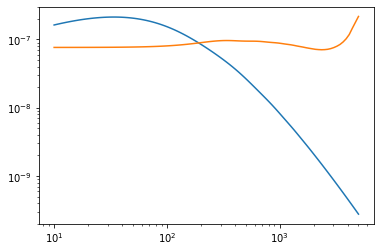

In [7]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [8]:
#<I Kappa>
f_KLIM   = get_f_KI()
f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)
trapz_Ik = d_delta_integral(f_KLIM_windowed, f_Kkappa)

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)
/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


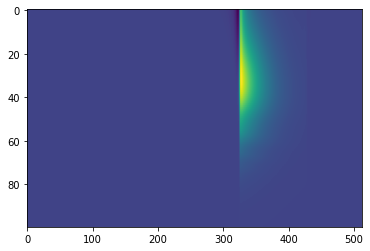

In [9]:
plt.imshow(trapz_Ik, aspect = 'auto')

In [10]:
from tqdm import trange

In [11]:
#<ILo Kappa>
ILok = np.zeros((len(ells), len(chis_resample)), dtype=np.float32)
external_chis = chis_resample.reshape(-1,1, 1, 1)

for i in trange(len(chis_resample) // 2**3):
    idx_left = i * 2**3
    idx_right = (i+1) * 2 ** 3
    f_KLIMLo = get_f_KILo(external_chi = external_chis[idx_left:idx_right], Lambda=Lambda)
    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)
    ILok[:, idx_left:idx_right] = d_chib_integral(f_KLIMLo_windowed, f_Kkappa).T

100%|██████████| 64/64 [02:51<00:00,  2.69s/it]


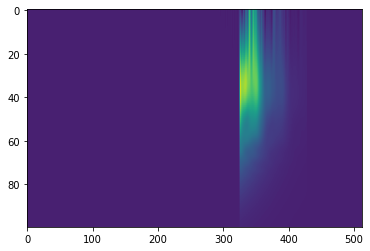

In [12]:
plt.imshow(ILok, aspect = 'auto')

In [13]:
integrand =  trapz_Ik**2 / (1/chis_resample**2) # [kJy^2/sr^2][Mpc^4]
# total integral has unit #[kJy^2 / sr^2][Mpc^3] 
SNR2_per_mode_nocut = simpson(x = chis_resample[window], y = integrand[:,window])/(ClKK + f_N0(ells)) 

In [14]:
IHi_kappa_orig = trapz_Ik - ILok

integrand =  IHi_kappa_orig**2 / (1/chis_resample**2) # [kJy^2/sr^2][Mpc^4]
# total integral has unit #[kJy^2 / sr^2][Mpc^3] 
SNR2_per_mode_orig = simpson(x = chis_resample[window], y = integrand[:,window])/(ClKK + f_N0(ells)) 

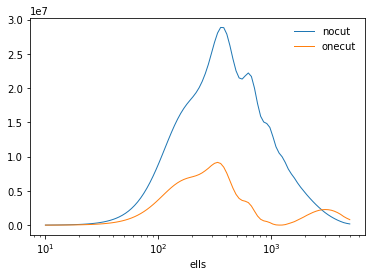

In [15]:
plt.figure(facecolor = 'w')
plt.plot(ells, ells**2 * SNR2_per_mode_nocut, lw = 1, label='nocut')
plt.plot(ells, ells**2 * SNR2_per_mode_orig, lw = 1, label='onecut')

plt.xscale('log')
plt.xlabel('ells')

plt.legend(frameon=False)

# turns out I figured it out, I dont need to inerp1d(sinc(...)) I can do stuff like sinc(...) times interp1d(...)
below is old when I hadnt figured this out and thought I needed to quad. trapezoid is good enough as long as I sample well enough. 

In [ ]:
## d_delta_integral but with quad_vec
from scipy.interpolate import interp1d
from scipy.integrate import quad_vec
from functools import cache

@cache
def d_delta_integral_quad_vec(f_Kpsi, f_Kphi):


    #integrand1
    f_psi_term = f_Kpsi(minus_args)
    f_phi_term = f_Kphi(plus_args)
    integrand1 = (f_psi_term * f_phi_term / chibs_reshaped**2 * 
                2 * chibs_reshaped * inner_dkparp_integral)

    #integrand2
    f_psi_term = f_Kpsi(plus_args)
    f_phi_term = f_Kphi(minus_args)
    integrand2 = (f_psi_term * f_phi_term / chibs_reshaped**2 * 
                2 * chibs_reshaped * inner_dkparp_integral)

    integrand = integrand1 + integrand2
    
    f_integrand = interp1d(x = np.log(deltas), y = integrand * deltas,
                          fill_value = 'extrapolate')
    oup, _ = quad_vec(f_integrand, np.log(min(deltas)), np.log(max(deltas)),
                     epsabs = 0.0, epsrel = 1e-3, workers = 32)
    return oup



In [ ]:
quad_Ik = d_delta_integral_quad_vec(f_KLIM_windowed, f_Kkappa)

In [ ]:
idxs = np.where(quad_Ik > 0)
frac_diff = np.zeros_like(quad_Ik)
frac_diff[idxs] = (quad_Ik[idxs] - trapz_Ik[idxs])/quad_Ik[idxs]

In [ ]:
cbound = np.max(np.abs(quad_Ik))
plt.imshow(quad_Ik, vmin = -cbound, vmax=cbound, cmap='seismic')
plt.show()
plt.imshow(trapz_Ik, vmin = -cbound, vmax=cbound, cmap='seismic')
plt.show()

In [ ]:
cbound = np.max(np.abs(frac_diff))
plt.imshow(frac_diff, vmin = -1, vmax=1, cmap='seismic')
plt.show()

In [ ]:
def d_chib_integral_outer_quad(f_Kpsi, f_Kphi):
    integrand = d_delta_integral(f_Kpsi, f_Kphi)
    f_integrand = interp1d(x = chibs, y = integrand)
    oup, _ = quad_vec(f_integrand, min(chibs), max(chibs),
                  epsabs = 0.0, epsrel = 1e-3, workers = 32)
    return oup

In [ ]:
from tqdm import tqdm

In [ ]:
#<ILo Kappa> quad outer
quadouter_ILok = np.zeros((len(ells), len(chibs)), dtype=np.float128)

from tqdm import trange

for chi_idx in tqdm(window):
    chi = chibs[chi_idx]
    f_KLIMLo   = get_f_KILo(external_chi = chi, Lambda=Lambda)
    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)
    quadouter_ILok[:, chi_idx] = d_chib_integral_outer_quad(f_KLIMLo_windowed, f_Kkappa)

In [ ]:
IHi_kappa_qouter = quad_Ik - quadouter_ILok

integrand =  IHi_kappa_qouter**2 / (1/chibs**2) # [kJy^2/sr^2][Mpc^4]
SNR2_per_mode_qouter = simpson(x = chibs[window], y = integrand[:,window])/(ClKK + f_N0(ells)) 

In [ ]:
plt.figure(facecolor = 'w')
plt.plot(ells, ells**2 * SNR2_per_mode_orig, lw = 1)
plt.plot(ells, ells**2 * SNR2_per_mode_nocut, lw = 1)
plt.plot(ells, ells**2 * SNR2_per_mode_qouter, 'k--', lw = 1,)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [ ]:
def d_chib_integral_quad_inner(f_Kpsi, f_Kphi):
    integrand = d_delta_integral_quad_vec(f_Kpsi, f_Kphi)
    oup = trapezoid(x = chibs, y = integrand)
    return oup

def d_chib_integral_quad_all(f_Kpsi, f_Kphi):
    integrand = d_delta_integral_quad_vec(f_Kpsi, f_Kphi)
    f_integrand = interp1d(x = chibs, y = integrand)
    oup, _ = quad_vec(f_integrand, min(chibs), max(chibs),
                  epsabs = 0.0, epsrel = 1e-3, workers = 32)
    return oup

In [ ]:
print(window)

In [ ]:
print(np.max(ILok))
np.min(np.abs(ILok))

In [ ]:
from tqdm import tqdm, trange

In [ ]:
cmax = np.max(np.abs(quad_Ik))
plt.imshow(quad_Ik, vmin = -cmax, vmax = cmax, cmap = 'seismic')
plt.show()
plt.imshow(ILok,  vmin = -cmax, vmax = cmax, cmap = 'seismic')

In [ ]:
#<ILo Kappa> quad inner
quadinner_ILok = np.zeros((len(ells), len(chibs)), dtype=np.float128)
quadall_ILok = np.zeros((len(ells), len(chibs)), dtype=np.float128)

from tqdm import trange

# for chi_idx in trange(len(chibs)):
for chi_idx in tqdm(window):
    chi = chibs[chi_idx]
    f_KLIMLo   = get_f_KILo(external_chi = chi, Lambda=Lambda)
    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)
    quadinner_ILok[:, chi_idx] = d_chib_integral_quad_inner(f_KLIMLo_windowed, f_Kkappa)
    quadall_ILok[:, chi_idx]   = d_chib_integral_quad_all(f_KLIMLo_windowed, f_Kkappa)

In [ ]:
IHi_kappa_quad_inner = quad_Ik - quadinner_ILok
integrand =  IHi_kappa_quad_inner**2 / (1/chibs**2) # [kJy^2/sr^2][Mpc^4]
f_integrand = interp1d(x = chibs, y = (integrand.T / (ClKK + f_N0(ells))).T)

# SNR2_per_mode_qinner = simpson(x = chibs[window], y = integrand[:,window])/(ClKK + f_N0(ells))
SNR2_per_mode_qinner, _ = quad_vec(f_integrand, chibs[window][0], chibs[window][-1], 
                                epsabs =0.0, epsrel = 1e-5)

In [ ]:
IHi_kappa_quad_all = quad_Ik - quadall_ILok
integrand =  IHi_kappa_quad_all**2 / (1/chibs**2) # [kJy^2/sr^2][Mpc^4]
f_integrand = interp1d(x = chibs, y = (integrand.T / (ClKK + f_N0(ells))).T)

# SNR2_per_mode_qinner = simpson(x = chibs[window], y = integrand[:,window])/(ClKK + f_N0(ells))
SNR2_per_mode_qall, _ = quad_vec(f_integrand, chibs[window][0], chibs[window][-1], 
                                epsabs =0.0, epsrel = 1e-5)

In [ ]:
plt.imshow(IHi_kappa_orig,  vmin = -cmax, vmax = cmax, cmap = 'seismic')
plt.show()
plt.imshow(IHi_kappa_quad_inner,  vmin = -cmax, vmax = cmax, cmap = 'seismic')
plt.show()
plt.imshow(IHi_kappa_quad_all,  vmin = -cmax, vmax = cmax, cmap = 'seismic')


In [ ]:
plt.figure(facecolor = 'w')
plt.plot(ells, ells**2 * SNR2_per_mode_orig, lw = 1)
plt.plot(ells, ells**2 * SNR2_per_mode_nocut, lw = 1)
plt.plot(ells, ells**2 * SNR2_per_mode_qinner, 'k--', lw = 1)
plt.plot(ells, ells**2 * SNR2_per_mode_qall, 'k--', lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)